# GidPy - Stage 2 : Deconvolution into Discrete Subpopulations using a General Mixture Model (GMM)

## About 

This is the second stage of the HidPy workflow. It loads the intermediate results generated from the analysis of the first stage and applies user-defined deconvolution models and plots the analysis results to complete the workflow.

## 2.1 Import the relevant packages

_Note: Please do NOT edit this panel._ 

In [11]:

## Imports and variables
from copyreg import pickle
import glob
import os
import sys 
from tqdm import tqdm
from pathlib import Path
import numpy as np

import warnings
warnings.filterwarnings('ignore') # Ignore all the warnings 

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

import core 
import core.plotting as cplot

from deconvolution import applyGMM_functions
from deconvolution import applyGMMconstrained_fitout_functions
from deconvolution import importDeconvolutionGMM

## 2.2 Input panel 

The user must update these parameters to match the parameters in Stage 1.2.

In [12]:
BayesMat = {} 
numDist = 3 # Choose maximum number of distributions

# Pickle files directory 
#pickle_files_directory = '%s/../output-protocol/rna/pickle/' % os.getcwd()
pickle_files_directory = '%s/../test_conditions/DataSiR_DNA/Pickles_file_16bits/U2OS_SiR_DNA_Serum_crops/' % os.getcwd()
#pickle_files_directory = '%s/../test_conditions/DataSiR_DNA/Pickles_file_16bits/U2OS_SiR_DNA_NoSerum_crops/' % os.getcwd()

# Parameters that will be deconvolved 
parameters2decon=['D','A','V']

# Number of bins of the histograms 
nbins=30

tick_count = 3

## 2.3 Deconvolution GMM

_Note: Please do NOT edit this panel._ 

100%|██████████| 19/19 [00:02<00:00,  7.43it/s]


Selection
Distribution type: ['lognormal', 'normal', 'lognormal']
Number of populations: [2 2 2]


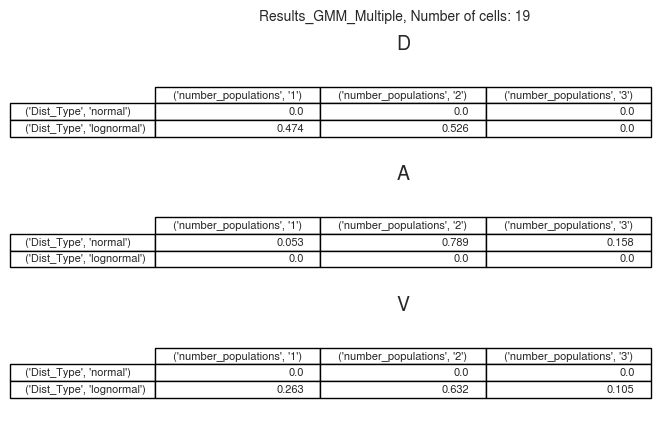

In [13]:
# Read cell pickle files
pickle_files = core.file_utils.list_files_in_directory(directory=pickle_files_directory, extension='.pickle')

# Dictionary with all the Bayes struct per cell
BayesMat=importDeconvolutionGMM.apply_gmm_on_multiple_files(pickle_files, parameters2decon, numDist) # Apply GMM

gmm_multiple_directory = '%s/gmm_multiple/' % pickle_files_directory
core.file_utils.create_directory(gmm_multiple_directory)

Sel_DistributionTypeAuto,Sel_numDistAuto=importDeconvolutionGMM.generatetable_TestGMM(gmm_multiple_directory, BayesMat, parameters2decon) # Make Table

print('Selection')
print("Distribution type: %s" % Sel_DistributionTypeAuto)
print("Number of populations: %s" % Sel_numDistAuto)

## 2.4 Plotting the GMM deconvolution results 

_Note: Please do NOT edit this panel._ 

In [14]:
from matplotlib.ticker import ScalarFormatter

def sample_range(start,
                 end,
                 steps):

    # Delta
    delta = 1. * (end - start) / (steps - 1)

    # Data
    data = list()
    for i in range(steps):
        value = start + i * delta
        data.append(value)

    return data

def generate_gmm_plots_for_all_parameters(output_directory, bayes, parameters, number_bins=30, font_size=14):

    import numpy as np
    import pickle
    from tqdm import tqdm
    import os
    import pandas as pd
    from matplotlib import pyplot as plt
    from scipy.stats import iqr
    from matplotlib import colors

    import seaborn
    from matplotlib import pyplot
    import matplotlib.pyplot as pyplot
    import matplotlib.font_manager as font_manager
    from matplotlib.ticker import FuncFormatter

    cplot.verify_plotting_packages()
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 1.0
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 1.0
    pyplot.rcParams['font.family'] = 'Helvetica LT Std'
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 1.0
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['axes.edgecolor'] = '1'
    

    # For every analysis result (or file)
    for i in tqdm(range(len(bayes))):

        # Get the file name 
        file_name = bayes[i]['filename']
        
        # File name without extension 
        filename_without_ext = os.path.splitext(file_name)[0]

        colors = ['r', 'r', 'r']

        figure_width = 8
        figure_height = 3
        
        
        # Create the new plot 
        fig, axs = plt.subplots(1, len(parameters), figsize=(figure_width, figure_height))
        fig.clf
        fig.suptitle('Result') #'Filename: '+os.path.basename(filename_without_ext), fontsize=10)
 
        # For every parameter that should be deconvolved 
        for j in range(len(parameters)):

            # Get the parameter that needs analysis 
            parameter = parameters[j]
            
            # Lists 
            xdata = list()
            x = list()

            # MAGIC
            xdata = bayes[i][parameter].reshape(-1, 1)
            xdata[np.where(np.isnan(xdata))] = 0
            xdata = xdata[np.where(xdata > 1e-10)]

            # Remove the outliers  
            if 'D' in parameter:
                data_filtered = list()
                for k in xdata:
                    if k < 0.0021:
                        data_filtered.append(k)
                xdata = data_filtered
            
            # Construct the histogram 
            n, bins, patches = axs[j].hist(xdata, edgecolor=colors[j], color=colors[j], density=True, bins=number_bins, alpha=0.2)
            x = np.arange(min(bins), max(bins), bins[1] - bins[0])


            weights = bayes[i]['Deconvolution'][parameter]['weights']
            mu = bayes[i]['Deconvolution'][parameter]['mu']
            sigma = bayes[i]['Deconvolution'][parameter]['sigma']
            DistributionType = bayes[i]['Deconvolution'][parameter]['DistributionType']
            number_populations = bayes[i]['Deconvolution'][parameter]['number_populations']
            model0 = bayes[i]['Deconvolution'][parameter]['model']
            
            axs[j].set_title('') #'DistType: '+DistributionType + ', # Populations: '+str(number_populations),fontsize=6)
            if 'D' in parameter:
                axs[j].set_xlabel('Diffusion Constant ($\mu$m$^2$/s)', fontsize=font_size)
            elif 'A' in parameter:
                axs[j].set_xlabel('Anomalous Exponent', fontsize=font_size)
            elif 'V' in parameter:
                axs[j].set_xlabel(r'Drift Velocity ($\mu$m/s)', fontsize=font_size)


            
            axs[j].xaxis.set_tick_params(labelsize=font_size)
            axs[j].yaxis.set_tick_params(labelsize=font_size)

            axs[j].xaxis.set_visible(True)
            axs[j].yaxis.set_visible(True)

            axs[j].spines['top'].set_color('none')
            axs[j].spines['right'].set_color('none')

            # Adjust the spines
            axs[j].spines["bottom"].set_color('black')
            axs[j].spines['bottom'].set_linewidth(1)
            axs[j].spines["left"].set_color('black')
            axs[j].spines['left'].set_linewidth(1)

            # Plot the ticks
            axs[j].tick_params(axis='x', width=1, which='both', bottom=True, direction="out")
            axs[j].tick_params(axis='y', width=1, which='both', left=True, direction="out")

            if 'D' in parameter:
                xticks = sample_range(min(bins), max(bins), 3)
                axs[j].set_xlim(0, 0.002)
                #axs[j].set_xticks(xticks)

            elif 'A' in parameter:
                xticks = sample_range(min(bins), max(bins), 3)
                axs[j].set_xlim(0, 1.0)
                #axs[j].set_xticks(xticks)
            
            else:
                xticks = sample_range(min(bins), max(bins), 3)
                axs[j].set_xlim(xticks[0], xticks[-1])
                #axs[j].set_xticks(xticks)

            
            axs[j].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            axs[j].get_xaxis().get_major_formatter().set_useOffset(True)

            difference = axs[j].get_ylim()[1] - axs[j].get_ylim()[0]
            yticks = sample_range(axs[j].get_ylim()[0], axs[j].get_ylim()[1] + (difference * 0.1), 4)
            axs[j].set_ylim(yticks[0], yticks[-1])
            axs[j].set_yticks(yticks)
            
            tempval=np.zeros(x.shape)

            if DistributionType == 'normal':
                for d in range(int(number_populations)):
                    axs[j].plot(x, weights[d]*applyGMM_functions.normal(x, mu[d], sigma[d]))
                    tempval= tempval+weights[d]*applyGMM_functions.normal(x, mu[d], sigma[d])
                axs[j].plot(x, tempval,'k')

            else:
                if number_populations==1:
                    param = model0.parameters
                    axs[j].plot(x, weights[0]*applyGMM_functions.lognormal(x,param[0],param[1]))
                else:
                    for d in range(int(number_populations)):           
                        param = model0.distributions[d].parameters
                        axs[j].plot(x, weights[d]*applyGMM_functions.lognormal((x), param[0],param[1]))
                        tempval= tempval+weights[d]*applyGMM_functions.lognormal((x), param[0],param[1])
                    axs[j].plot(x, tempval,'k')

            fig.tight_layout(pad=0.5)
        fig.savefig('%s/d_a_v_multiple.png' % output_directory, dpi=300, bbox_inches='tight', pad_inches=0)
        
    

## 2.5 GMM Multiple

_Note: Please do NOT edit this panel._ 

100%|██████████| 19/19 [00:09<00:00,  2.11it/s]


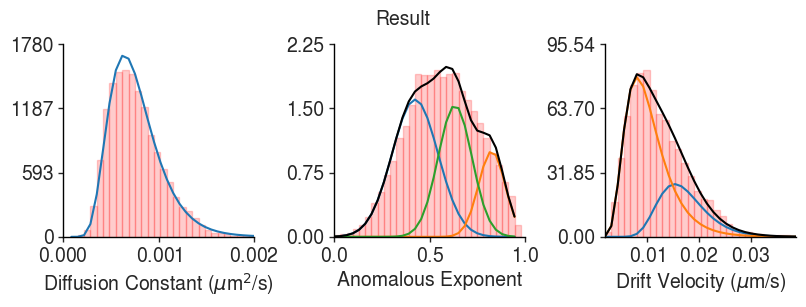

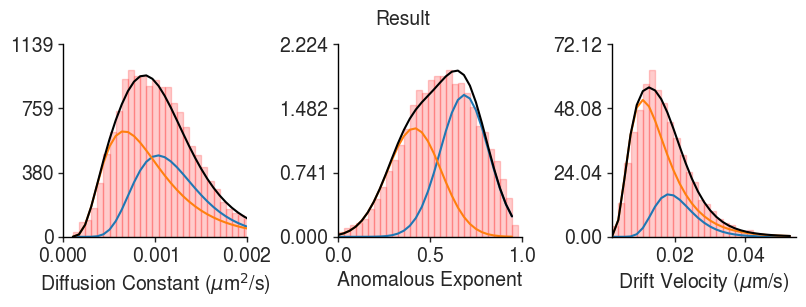

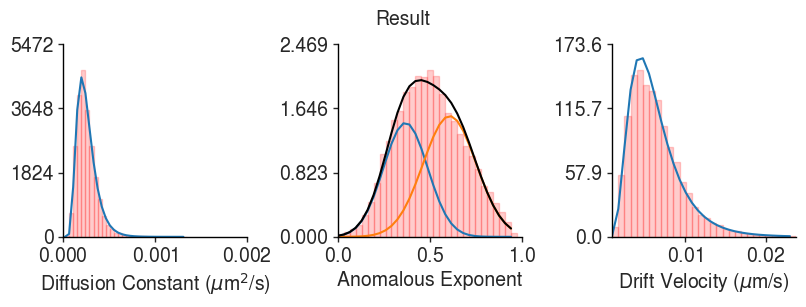

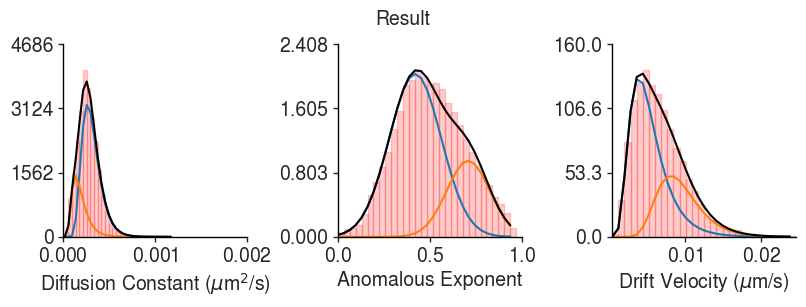

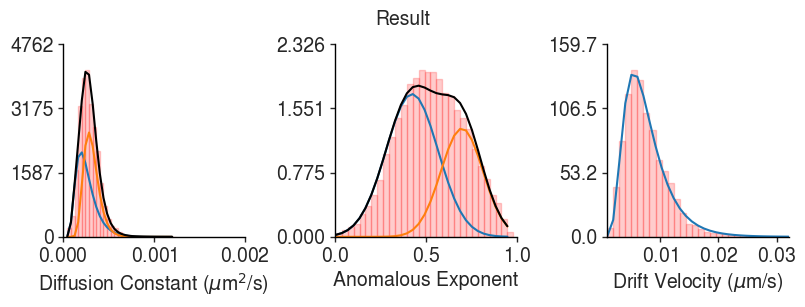

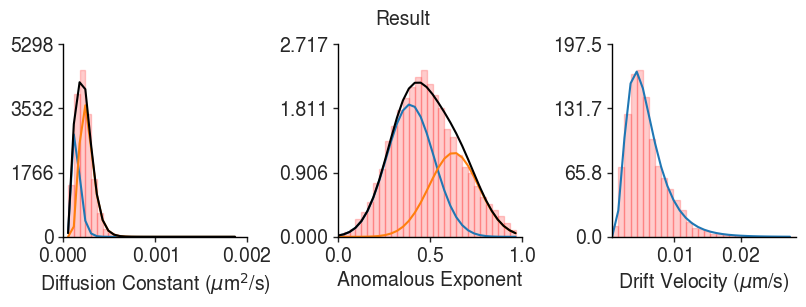

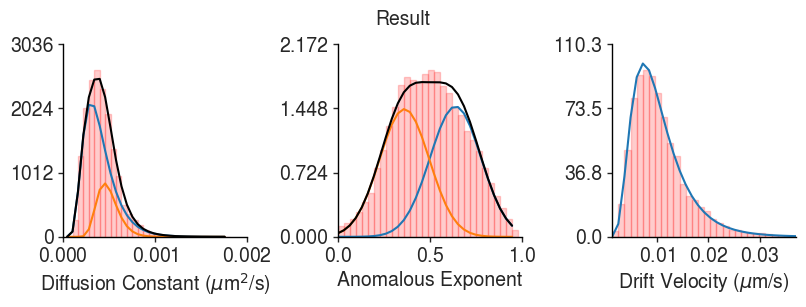

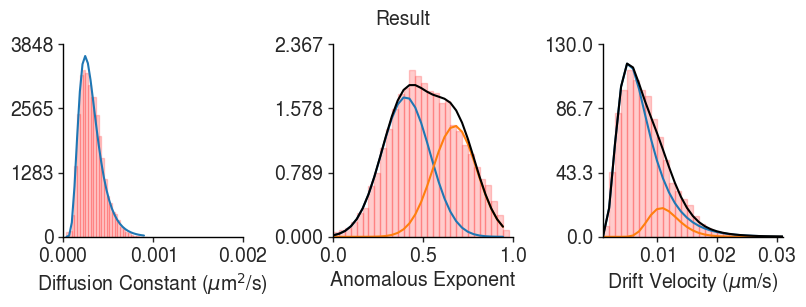

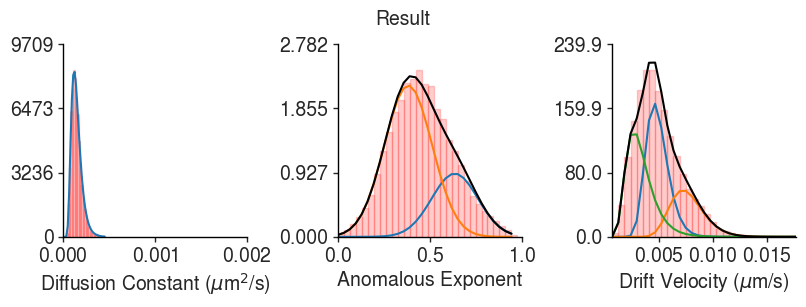

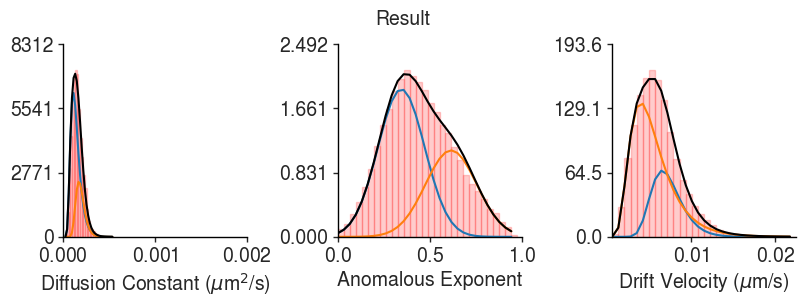

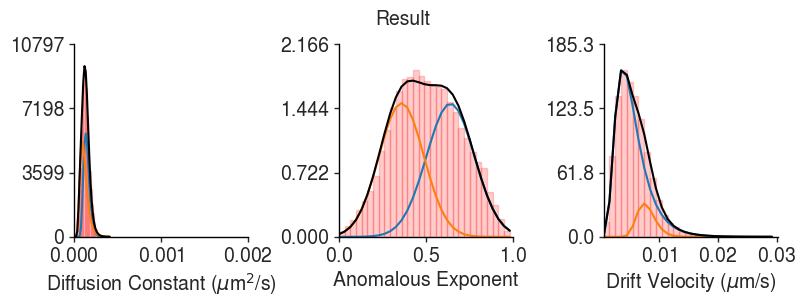

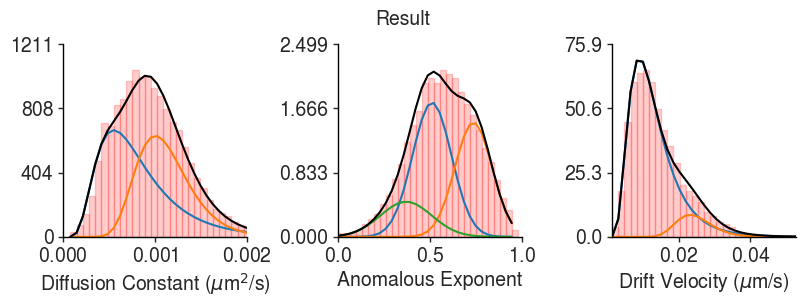

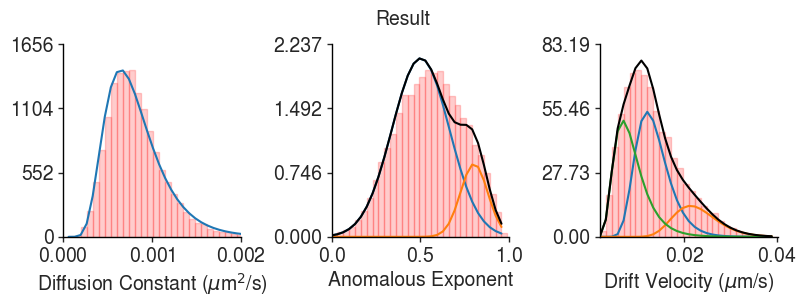

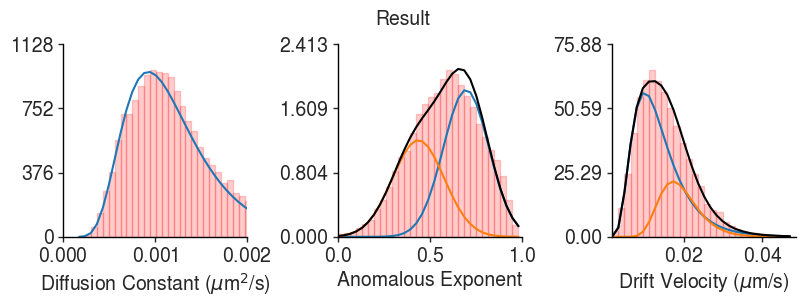

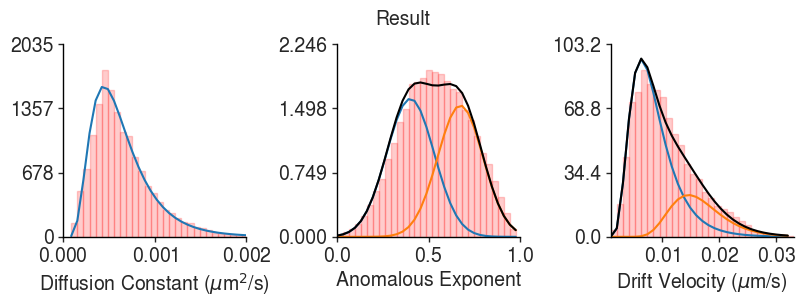

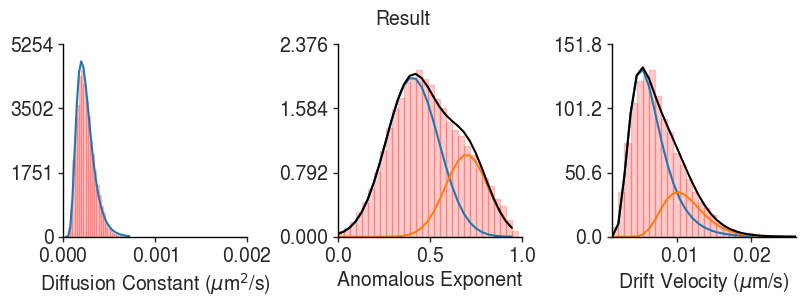

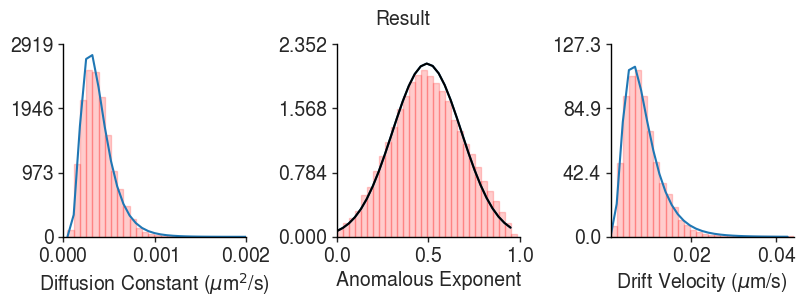

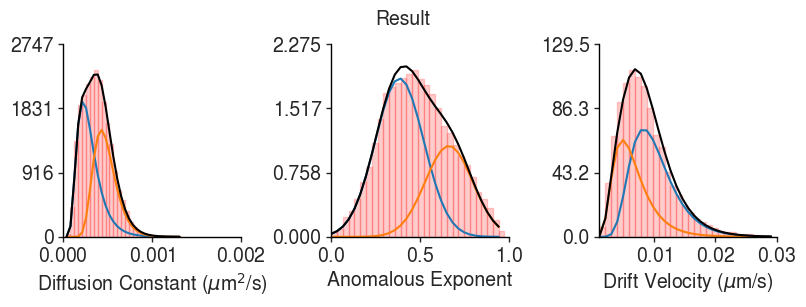

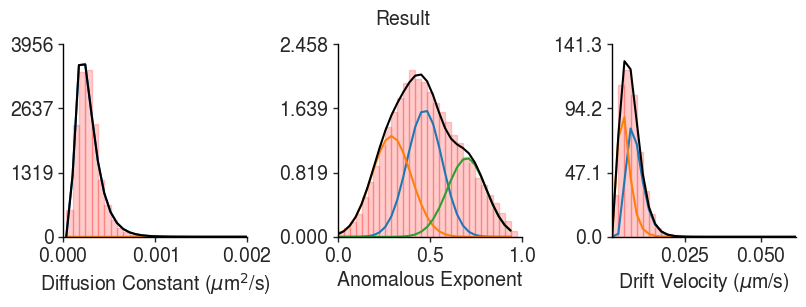

In [15]:
# Generating plots for inspection
showplots = True

generate_gmm_plots_for_all_parameters(
    output_directory=gmm_multiple_directory, bayes=BayesMat, 
    parameters=parameters2decon, number_bins=nbins)
# importDeconvolutionGMM.generateplots_TestGMM(gmm_multiple_directory, BayesMat, parameters2decon, nbins, showplots)

## 2.6 Run GMM based on table and plots for each parameter [D A V]

The user can edit the distribution type and the number of corresponding subpopulations.

In [16]:
# # Manual Selection
# Sel_DistributionType=['lognormal','normal','lognormal']
# Sel_numDist=[2,2,2]

# Automatic Selection
Sel_DistributionType=Sel_DistributionTypeAuto
Sel_numDist=Sel_numDistAuto

BayesMatSel=importDeconvolutionGMM.applyGMMconstrained_dir(pickle_files,parameters2decon,Sel_DistributionType,Sel_numDist)

100%|██████████| 19/19 [00:22<00:00,  1.16s/it]


In [17]:

from numpy import number


def generateplots_GMMconstrained_fitout(pathBayesCells_Plots,BayesMat,parameters2decon,nbins,Sel_DistributionType,Sel_numDist,showplots):

    import numpy as np
    import pickle
    from tqdm import tqdm
    import os
    import pandas as pd
    from matplotlib import pyplot as plt
    from scipy.stats import iqr
    from matplotlib import colors

    import seaborn
    from matplotlib import pyplot
    import matplotlib.pyplot as pyplot
    import matplotlib.font_manager as font_manager
    from matplotlib.ticker import FuncFormatter

    font_size=8

    cplot.verify_plotting_packages()
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 1.0
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 1.0
    pyplot.rcParams['font.family'] = 'Helvetica LT Std'
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 1.0
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['axes.edgecolor'] = '1'

    
    for i in tqdm(range(len(BayesMat))):

        filename=BayesMat[i]['filename']
        filename_without_ext = os.path.splitext(filename)[0]
        
        colors = ['g', 'g', 'g']
        figure_width = 8
        figure_height = 3

        fig, axs = plt.subplots(1, len(parameters2decon), figsize=(figure_width, figure_height))
        fig.clf
        fig.suptitle('') #  'Results_constrained. Filename: '+os.path.basename(filename_without_ext), fontsize=10)

        
        for count3 in range(len(parameters2decon)):
            parameter2analyse=parameters2decon[count3]
            xdata=[]
            x=[]

            xdata=BayesMat[i][parameter2analyse].reshape(-1, 1)
            xdata[np.where(np.isnan(xdata))]=0
            xdata=xdata[np.where(xdata>1e-10)]

            # Remove the outliers  
            if 'D' in parameter2analyse:
                data_filtered = list()
                for k in xdata:
                    if k < 0.0021:
                        data_filtered.append(k)
                xdata = data_filtered

            n,bins,patches=axs[count3].hist(xdata, edgecolor=colors[i], color=colors[i], density=True, bins=nbins, alpha=0.3);
            x=np.arange(min(bins),max(bins),bins[1]-bins[0])

            weights= BayesMat[i]['Deconvolution'][parameter2analyse]['weights']
            mu=BayesMat[i]['Deconvolution'][parameter2analyse]['mu']
            sigma=BayesMat[i]['Deconvolution'][parameter2analyse]['sigma']
            DistributionType=Sel_DistributionType[count3]
            number_populations=Sel_numDist[count3]
            model0=BayesMat[i]['Deconvolution'][parameter2analyse]['model']
            


            title = ''
            if 'lognormal' in DistributionType:
                title += 'Distribution: Log-normal \n'
            elif 'normal' in DistributionType:
                title += 'Distribution: Normal \n'
            
            title += '# Populations: ' + str(number_populations)
            #axs[count3].set_title('Dist Type: '+DistributionType + ', # Populations: '+str(number_populations),fontsize=12)
            axs[count3].set_title(title,fontsize=8)
            
           
            ##
            axs[count3].xaxis.set_tick_params(labelsize=font_size)
            axs[count3].yaxis.set_tick_params(labelsize=font_size)

            axs[count3].xaxis.set_visible(True)
            axs[count3].yaxis.set_visible(True)

            axs[count3].spines['top'].set_color('none')
            axs[count3].spines['right'].set_color('none')

            # Adjust the spines
            axs[count3].spines["bottom"].set_color('black')
            axs[count3].spines['bottom'].set_linewidth(1)
            axs[count3].spines["left"].set_color('black')
            axs[count3].spines['left'].set_linewidth(1)

            # Plot the ticks
            axs[count3].tick_params(axis='x', width=1, which='both', bottom=True, direction="out")
            axs[count3].tick_params(axis='y', width=1, which='both', left=True, direction="out")

            if 'D' in parameter2analyse:
                xticks = sample_range(min(bins), max(bins), 3)
                axs[count3].set_xlim(0, 0.002)
                #axs[j].set_xticks(xticks)

            elif 'A' in parameter2analyse:
                xticks = sample_range(min(bins), max(bins), 3)
                axs[count3].set_xlim(0, 1.0)
                #axs[j].set_xticks(xticks)
            
            else:
                xticks = sample_range(min(bins), max(bins), 3)
                axs[count3].set_xlim(xticks[0], xticks[-1])
                #axs[j].set_xticks(xticks)

            
            axs[count3].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            axs[count3].get_xaxis().get_major_formatter().set_useOffset(True)



            
            difference = axs[count3].get_ylim()[1] - axs[count3].get_ylim()[0]
            yticks = sample_range(axs[count3].get_ylim()[0], axs[count3].get_ylim()[1] + (difference * 0.1), 4)
            axs[count3].set_ylim(yticks[0], yticks[-1])
            axs[count3].set_yticks(yticks)

            ##

            #axs[count3].set_title('') #'DistType: '+DistributionType + ', # Populations: '+str(number_populations),fontsize=6)
            #axs[count3].set_xlabel(parameter2analyse, fontsize=10)

            if 'D' in parameter2analyse:
                axs[count3].set_xlabel('Diffusion Constant ($\mu$m$^2$/s)', fontsize=font_size)
            elif 'A' in parameter2analyse:
               axs[count3].set_xlabel('Anomalous Exponent', fontsize=font_size)
            elif 'V' in parameter2analyse:
               axs[count3].set_xlabel(r'Drift Velocity ($\mu$m/s)', fontsize=font_size)
            
            
            tempval=np.zeros(x.shape)

            if DistributionType == 'normal':
                for d in range(int(number_populations)):
                    axs[count3].plot(x, weights[d]*applyGMM_functions.normal(x, mu[d], sigma[d]))
                    tempval= tempval+weights[d]*applyGMM_functions.normal(x, mu[d], sigma[d])
                axs[count3].plot(x, tempval,'k')

            else:
                if number_populations==1:
                    param = model0.parameters
                    axs[count3].plot(x, weights[0]*applyGMM_functions.lognormal(x,param[0],param[1]))
                else:
                    for d in range(int(number_populations)):           
                        param = model0.distributions[d].parameters
                        axs[count3].plot(x, weights[d]*applyGMM_functions.lognormal((x), param[0],param[1]))
                        tempval= tempval+weights[d]*applyGMM_functions.lognormal((x), param[0],param[1])
                    axs[count3].plot(x, tempval,'k')

            fig.tight_layout(pad=0.5)
        fig.savefig('%s/d_a_v_constrained.png' % pathBayesCells_Plots, dpi=300, bbox_inches='tight', pad_inches=0)

## 2.7 Generate the GMM Constrained Plot

100%|██████████| 19/19 [00:10<00:00,  1.74it/s]


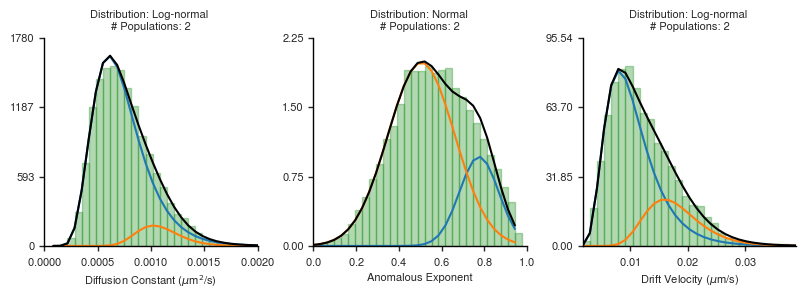

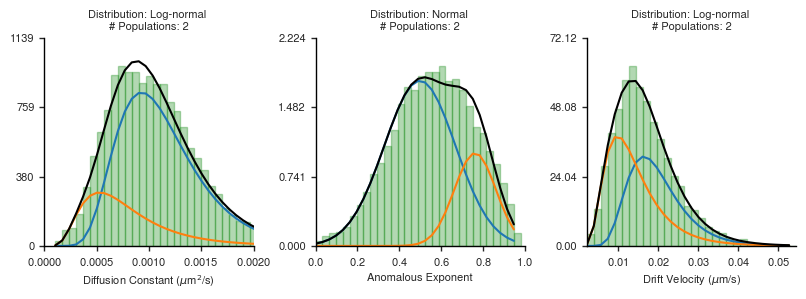

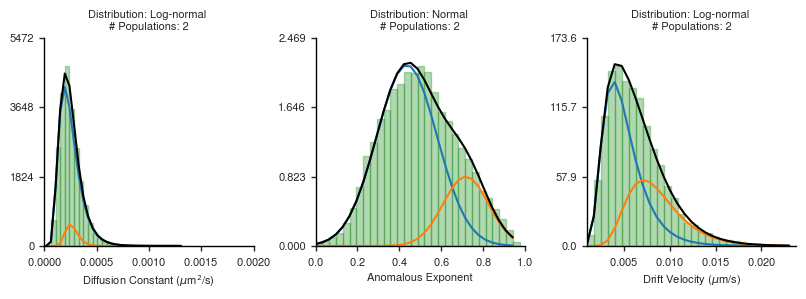

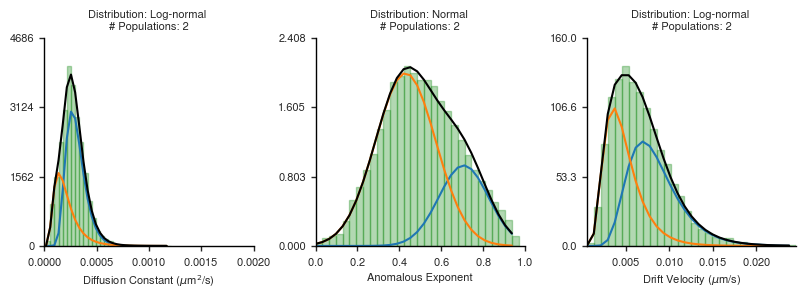

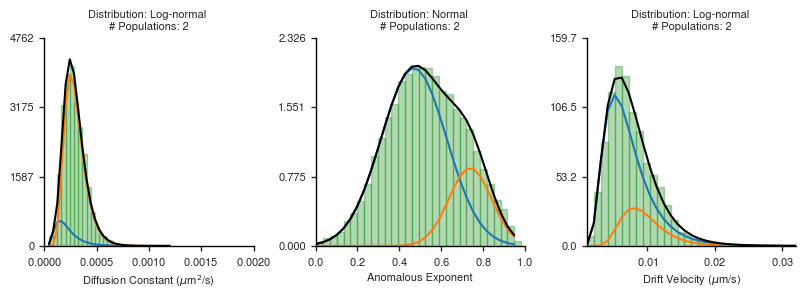

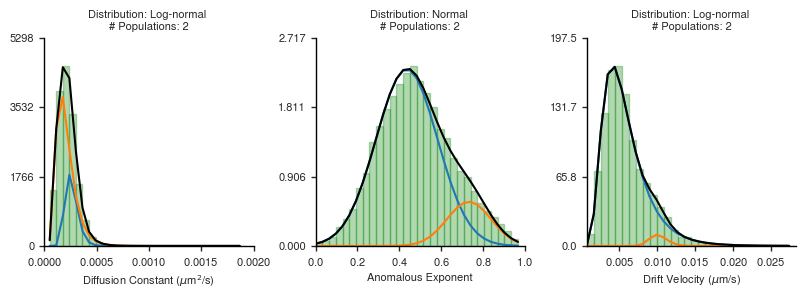

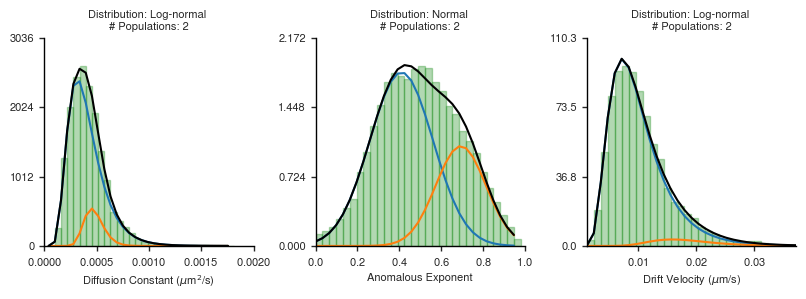

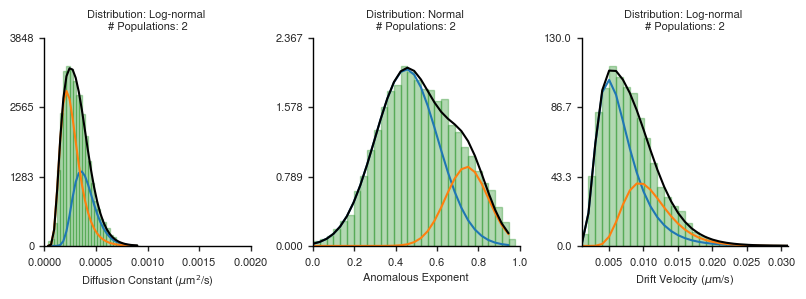

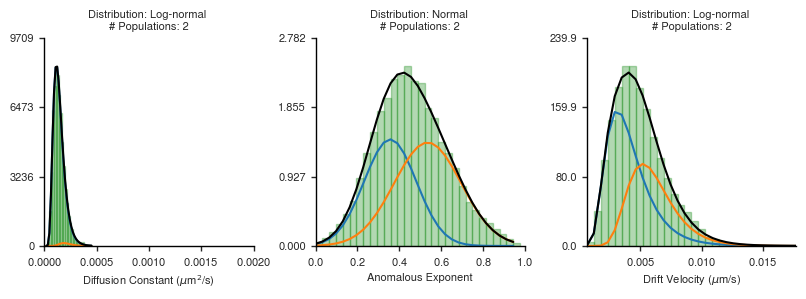

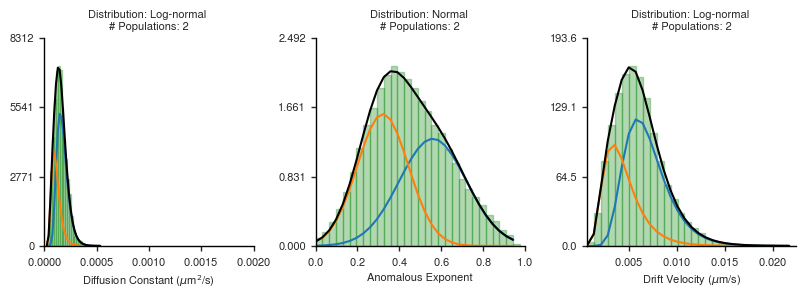

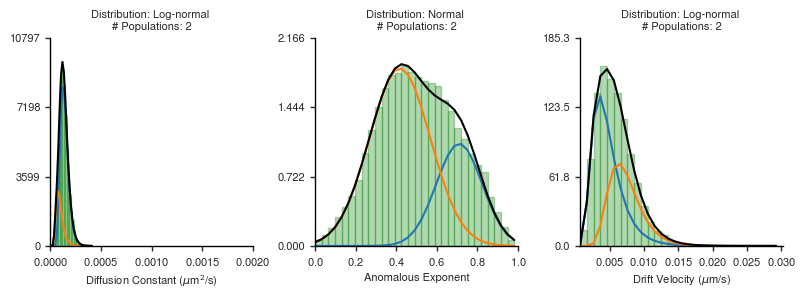

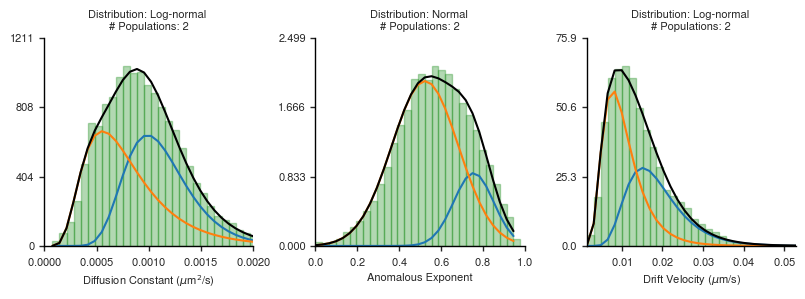

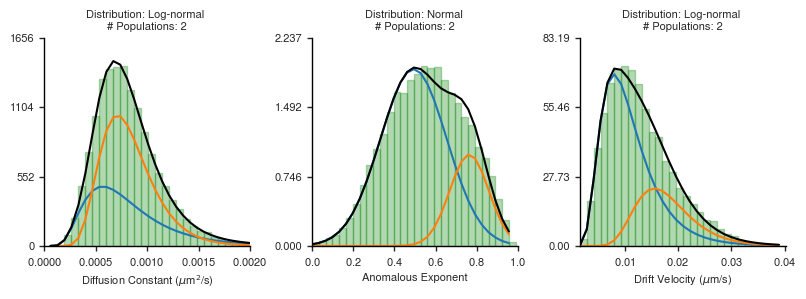

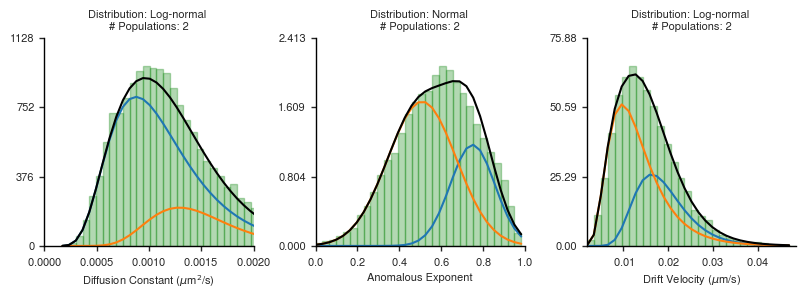

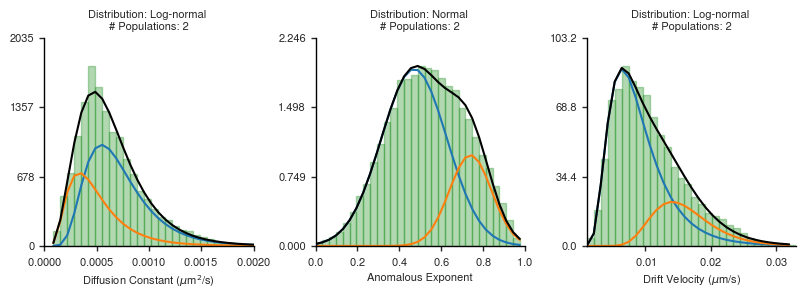

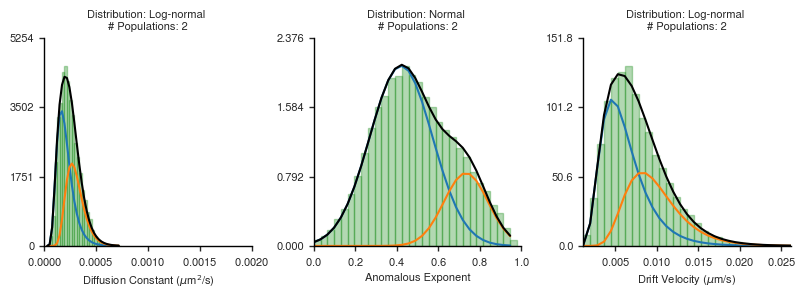

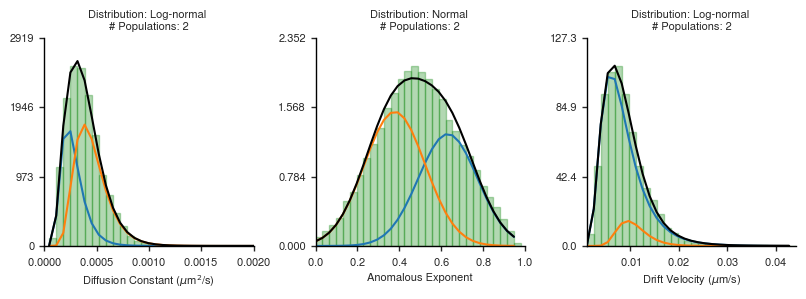

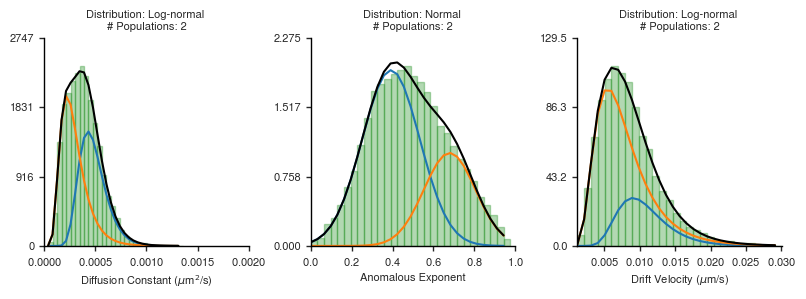

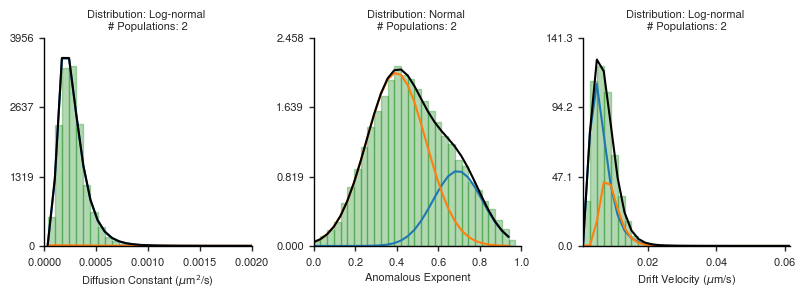

In [18]:
# Generate plots GMM constrained
def generateplots_GMMconstrained_fitout(pathBayesCells_Plots,BayesMat,parameters2decon,nbins,Sel_DistributionType,Sel_numDist,showplots):

    import numpy as np
    import pickle
    from tqdm import tqdm
    import os
    import pandas as pd
    from matplotlib import pyplot as plt
    from scipy.stats import iqr
    from matplotlib import colors

    import seaborn
    from matplotlib import pyplot
    import matplotlib.pyplot as pyplot
    import matplotlib.font_manager as font_manager
    from matplotlib.ticker import FuncFormatter

    font_size=8

    cplot.verify_plotting_packages()
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 1.0
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 1.0
    pyplot.rcParams['font.family'] = 'Helvetica LT Std'
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 1.0
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['axes.edgecolor'] = '1'

    
    for i in tqdm(range(len(BayesMat))):

        filename=BayesMat[i]['filename']
        filename_without_ext = os.path.splitext(filename)[0]
        
        try:
            colors = ['g', 'g', 'g']
            figure_width = 8
            figure_height = 3

            fig, axs = plt.subplots(1, len(parameters2decon), figsize=(figure_width, figure_height))
            fig.clf
            fig.suptitle('') #  'Results_constrained. Filename: '+os.path.basename(filename_without_ext), fontsize=10)

        
            for count3 in range(len(parameters2decon)):
                parameter2analyse=parameters2decon[count3]
                xdata=[]
                x=[]

                xdata=BayesMat[i][parameter2analyse].reshape(-1, 1)
                xdata[np.where(np.isnan(xdata))]=0
                xdata=xdata[np.where(xdata>1e-10)]

                # Remove the outliers  
                if 'D' in parameter2analyse:
                    data_filtered = list()
                    for k in xdata:
                        if k < 0.0021:     #adapt default:0.0021
                            data_filtered.append(k)
                    xdata = data_filtered     
                
                n,bins,patches=axs[count3].hist(xdata, edgecolor=colors[count3], color=colors[count3], density=True, bins=nbins, alpha=0.3)
                x=np.arange(min(bins),max(bins),bins[1]-bins[0])

                weights= BayesMat[i]['Deconvolution'][parameter2analyse]['weights']
                mu=BayesMat[i]['Deconvolution'][parameter2analyse]['mu']
                sigma=BayesMat[i]['Deconvolution'][parameter2analyse]['sigma']
                DistributionType=Sel_DistributionType[count3]
                number_populations=Sel_numDist[count3]
                model0=BayesMat[i]['Deconvolution'][parameter2analyse]['model']
            


                title = ''
                if 'lognormal' in DistributionType:
                    title += 'Distribution: Log-normal \n'
                elif 'normal' in DistributionType:
                    title += 'Distribution: Normal \n'
            
                title += '# Populations: ' + str(number_populations)
                #axs[count3].set_title('Dist Type: '+DistributionType + ', # Populations: '+str(number_populations),fontsize=12)
                axs[count3].set_title(title,fontsize=8)
            
           
                ##
                axs[count3].xaxis.set_tick_params(labelsize=font_size)
                axs[count3].yaxis.set_tick_params(labelsize=font_size)

                axs[count3].xaxis.set_visible(True)
                axs[count3].yaxis.set_visible(True)

                axs[count3].spines['top'].set_color('none')
                axs[count3].spines['right'].set_color('none')

                # Adjust the spines
                axs[count3].spines["bottom"].set_color('black')
                axs[count3].spines['bottom'].set_linewidth(1)
                axs[count3].spines["left"].set_color('black')
                axs[count3].spines['left'].set_linewidth(1)

                # Plot the ticks
                axs[count3].tick_params(axis='x', width=1, which='both', bottom=True, direction="out")
                axs[count3].tick_params(axis='y', width=1, which='both', left=True, direction="out")

                if 'D' in parameter2analyse:
                    xticks = sample_range(min(bins), max(bins), 3)
                    axs[count3].set_xlim(0, 0.002)
                    #axs[j].set_xticks(xticks)

                elif 'A' in parameter2analyse:
                    xticks = sample_range(min(bins), max(bins), 3)
                    axs[count3].set_xlim(0, 1.0)
                    #axs[j].set_xticks(xticks)
            
                else:
                    xticks = sample_range(min(bins), max(bins), 3)
                    axs[count3].set_xlim(xticks[0], xticks[-1])
                    #axs[j].set_xticks(xticks)

            
                axs[count3].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
                axs[count3].get_xaxis().get_major_formatter().set_useOffset(True)



            
                difference = axs[count3].get_ylim()[1] - axs[count3].get_ylim()[0]
                yticks = sample_range(axs[count3].get_ylim()[0], axs[count3].get_ylim()[1] + (difference * 0.1), 4)
                axs[count3].set_ylim(yticks[0], yticks[-1])
                axs[count3].set_yticks(yticks)

            ##

                #axs[count3].set_title('') #'DistType: '+DistributionType + ', # Populations: '+str(number_populations),fontsize=6)
                #axs[count3].set_xlabel(parameter2analyse, fontsize=10)

                if 'D' in parameter2analyse:
                    axs[count3].set_xlabel('Diffusion Constant ($\mu$m$^2$/s)', fontsize=font_size)
                elif 'A' in parameter2analyse:
                    axs[count3].set_xlabel('Anomalous Exponent', fontsize=font_size)
                elif 'V' in parameter2analyse:
                    axs[count3].set_xlabel(r'Drift Velocity ($\mu$m/s)', fontsize=font_size)
            
            
                tempval=np.zeros(x.shape)

                if DistributionType == 'normal':
                    for d in range(int(number_populations)):
                        axs[count3].plot(x, weights[d]*applyGMM_functions.normal(x, mu[d], sigma[d]))
                        tempval= tempval+weights[d]*applyGMM_functions.normal(x, mu[d], sigma[d])
                    axs[count3].plot(x, tempval,'k')

                else:
                    if number_populations==1:
                        param = model0.parameters
                        axs[count3].plot(x, weights[0]*applyGMM_functions.lognormal(x,param[0],param[1]))
                    else:
                        for d in range(int(number_populations)):           
                            param = model0.distributions[d].parameters
                            axs[count3].plot(x, weights[d]*applyGMM_functions.lognormal((x), param[0],param[1]))
                            tempval= tempval+weights[d]*applyGMM_functions.lognormal((x), param[0],param[1])
                        axs[count3].plot(x, tempval,'k')

                fig.tight_layout(pad=0.5)
            fig.savefig('%s/d_a_v_constrained.png' % pathBayesCells_Plots, dpi=300, bbox_inches='tight', pad_inches=0)

        except Exception as e:
            print(e.args)
            print('Error in file: '+filename_without_ext)
            
gmm_constrained_directory = '%s/gmm_constrained/' % pickle_files_directory
core.file_utils.create_directory(gmm_constrained_directory)

showplots=True

#importDeconvolutionGMM.generateplots_GMMconstrained_fitout(
#    gmm_constrained_directory, BayesMatSel, parameters2decon, nbins, Sel_DistributionType, Sel_numDist, showplots)

generateplots_GMMconstrained_fitout(
    gmm_constrained_directory, BayesMatSel, parameters2decon, nbins, Sel_DistributionType, Sel_numDist, showplots)


## 2.8 Deconvolution Statistics: Generate Spatial Mapping of Population Deconvolution

In [19]:
showplots=False

####################################################################################################
# @sample_range
####################################################################################################
def sample_range(start,
                 end,
                 steps):

    # Delta
    delta = 1. * (end - start) / (steps - 1)

    # Data
    data = list()
    for i in range(steps):
        value = start + i * delta
        data.append(value)

    return data

def generate_plots_stats_decon(BayesMatSel,param,output_directory,showplots, tick_count=5):

    
    from matplotlib import colors, pyplot
    import seaborn
    font_size = 14
    import numpy
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 0.5
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 0.25
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 0.5
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['xtick.major.pad'] = '1'
    pyplot.rcParams['ytick.major.pad'] = '1'
    pyplot.rcParams['axes.edgecolor'] = '0'
    pyplot.rcParams['axes.autolimit_mode'] = 'round_numbers'
    from matplotlib import colors, pyplot
    import seaborn

    import numpy
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

    labels = BayesMatSel['Deconvolution'][param]['labels']
    unique_labels = np.unique(labels)
    thresh = []

    for label in unique_labels:
        data_in_label = BayesMatSel['Deconvolution'][param]['GMM_input'][labels==label]
        thresh.append( np.max(data_in_label))

    thresh = np.sort(thresh)[:-1] # the last entry is not actually a threshold

    # map distributions back to nucleus
    labels_map = np.zeros(BayesMatSel[param].shape, dtype=int)
    numPop = len(thresh)+1
    for t in range(numPop):
        assigned_label = t+1    
        if t == 0:
            labels_map[BayesMatSel[param]<=thresh[t]] = assigned_label
        elif t > 0 and t<numPop-1:
            labels_map[ np.logical_and(BayesMatSel[param]>thresh[t-1], BayesMatSel[param]<=thresh[t]) ] = assigned_label
        else:
            labels_map[BayesMatSel[param]>thresh[t-1]] = assigned_label
    labels_map[BayesMatSel[param]==0] = 0

    
    #fig,ax=plt.subplots(1,2,figsize=[10,5])
    # Plot 
    fig, ax = pyplot.subplots()
        
    listcolors=['w','g','b','purple','r','greenyellow']
    cmap = colors.ListedColormap(listcolors[0:numPop+1])

    # Create the ticks of the images 
    xticks = sample_range(0, labels_map.shape[0], tick_count)
    yticks = sample_range(0, labels_map.shape[1], tick_count)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # Color-basr axis 
    #cax = ax.inset_axes([0.00, -0.20, 1.0, 0.05])

    img1=ax.imshow(labels_map, interpolation='nearest', cmap=cmap,origin='lower')
    cbar=fig.colorbar(img1,   ax=ax,spacing='proportional',orientation='vertical',boundaries=[-0.5] + bounds[0:numPop+1] + [numPop+0.5])
    cbar.outline.set_color('black')
    cbar.outline.set_linewidth(1)
    labels_cbar = np.arange(0, numPop+1, 1)
    loc = labels_cbar
    cbar.set_ticks(loc)

    if 'D' in param:
        title = r'Diffusion Constant ($\mu$m$^2$/s)'
    elif 'A' in param:
        title = 'Anomalous Exponent'
    elif 'V' in param:
        title = r'Drift Velocity ($\mu$m/s)'
    else:
        print('ERROR')

    #
    ax.set_title(title)

    #output_directory=pickle_files_directory
    #frame_prefix=param

    # Save the figure 
    pyplot.savefig('%s/%s_deconvolution.png' % (output_directory, param), dpi=300, bbox_inches='tight', pad_inches=0)


statsMat={}
for i in range(len(BayesMatSel)):
    statsMat[f'File_{i+1}']={}
    for j in range(len(parameters2decon)):
        statsMat[f'File_{i+1}'][parameters2decon[j]]=[]


## I use importDeconvolutionGMM.generate_plots_stats_decon to use in the last notebook because i have the statistics there
for i in tqdm(range(len(BayesMatSel))):
    for j in range(len(parameters2decon)):
        
        try:
            statsMat[f'File_{i+1}'][parameters2decon[j]]=importDeconvolutionGMM.generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],gmm_constrained_directory,showplots)
            
            # generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],pathBayesCells_Populations_Plots,showplots)

        except:
            filename_without_ext = os.path.splitext(BayesMatSel[i]['filename'])[0]
            print('WARNING: Error generating population label plot: File: '+filename_without_ext+' Parameter: '+parameters2decon[j])

# To be used to validate plots
# for i in tqdm(range(len(BayesMatSel))):
#     for j in range(len(parameters2decon)):
        
#         try:
#             #importDeconvolutionGMM.generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],pathBayesCells_Populations_Plots,showplots)
#             generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],gmm_constrained_directory,showplots, tick_count=tick_count)

#         except:
#             filename_without_ext = os.path.splitext(BayesMatSel[i]['filename'])[0]
#             print('WARNING: Error generating population label plot: File: '+filename_without_ext+' Parameter: '+parameters2decon[j])


  0%|          | 0/19 [00:00<?, ?it/s]

Verify Package!
Verify Package!
Verify Package!


  5%|▌         | 1/19 [00:00<00:04,  4.24it/s]

Verify Package!
Verify Package!


 11%|█         | 2/19 [00:00<00:05,  3.22it/s]

Verify Package!
Verify Package!
Verify Package!


 16%|█▌        | 3/19 [00:00<00:04,  3.61it/s]

Verify Package!
Verify Package!
Verify Package!
Verify Package!


 21%|██        | 4/19 [00:01<00:04,  3.31it/s]

Verify Package!
Verify Package!


 32%|███▏      | 6/19 [00:01<00:02,  4.53it/s]

Verify Package!
Verify Package!
Verify Package!
Verify Package!
Verify Package!
Verify Package!


 37%|███▋      | 7/19 [00:01<00:02,  5.30it/s]

Verify Package!
Verify Package!
Verify Package!


 42%|████▏     | 8/19 [00:02<00:02,  4.06it/s]

Verify Package!
Verify Package!
Verify Package!


 47%|████▋     | 9/19 [00:02<00:02,  3.99it/s]

Verify Package!
Verify Package!
Verify Package!
Verify Package!


 53%|█████▎    | 10/19 [00:02<00:03,  2.60it/s]

Verify Package!
Verify Package!


 58%|█████▊    | 11/19 [00:03<00:03,  2.60it/s]

Verify Package!
Verify Package!
Verify Package!
Verify Package!


 63%|██████▎   | 12/19 [00:03<00:02,  2.58it/s]

Verify Package!
Verify Package!


 68%|██████▊   | 13/19 [00:04<00:02,  2.54it/s]

Verify Package!
Verify Package!
Verify Package!


 74%|███████▎  | 14/19 [00:04<00:01,  2.87it/s]

Verify Package!
Verify Package!
Verify Package!
Verify Package!


 79%|███████▉  | 15/19 [00:04<00:01,  2.83it/s]

Verify Package!
Verify Package!


 84%|████████▍ | 16/19 [00:05<00:01,  2.85it/s]

Verify Package!
Verify Package!


 89%|████████▉ | 17/19 [00:05<00:00,  2.79it/s]

Verify Package!
Verify Package!
Verify Package!


 95%|█████████▍| 18/19 [00:05<00:00,  3.15it/s]

Verify Package!
Verify Package!
Verify Package!
Verify Package!
Verify Package!


100%|██████████| 19/19 [00:06<00:00,  3.14it/s]


In [20]:
# Save pickle file per cell
import pickle
from core import file_utils

# Create the pickle directory 
pickle_directory = '%s/pickle' % gmm_constrained_directory
file_utils.create_directory(pickle_directory)

# Save the pickle file 
with open('%s/Statistics.pickle' % (pickle_directory), 'wb') as f:
    pickle.dump(statsMat, f)

# For testing in Matlab to be removed before submission
from scipy.io import savemat
savemat(pickle_directory+"/Statistics.mat",statsMat)

## 2.10 Create the HTML Report 

Generate an HTML report summarizing and tabulating the analysis results of Stage 2.